In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.model_selection import KFold
from scipy.stats import t

In [101]:
metadata = pd.read_csv("metadata.csv",header=0,index_col=0)
microbiome = pd.read_csv("microbiome.csv",header=0,index_col=0)
metabolome = pd.read_csv("serum_lipo.csv",header=0,index_col=0)

In [102]:
def clr_transform(df: pd.DataFrame, epsilon=1e-6) -> pd.DataFrame:
    clr_df = df.fillna(0.0).astype(float).values
    clr_df = np.log(clr_df + epsilon)
    clr_df = clr_df - clr_df.mean(axis=1, keepdims=True)
    return pd.DataFrame(clr_df, index=df.index, columns=df.columns)
def standartization_transform(train_df, test_df):
    scaler = StandardScaler().fit(train_df)
    train_scaled = pd.DataFrame(scaler.transform(train_df), index=train_df.index, columns=train_df.columns)
    test_scaled = pd.DataFrame(scaler.transform(test_df), index=test_df.index, columns=test_df.columns)
    return train_scaled, test_scaled

In [103]:
microbiome_train, microbiome_test, diseases_train, diseases_test = train_test_split(microbiome, metadata[['PATGROUPFINAL_C']], train_size=0.8, random_state=42)
microbiome_train = clr_transform(microbiome_train)
microbiome_test = clr_transform(microbiome_test)
train_indices = microbiome_train.index
test_indices  = microbiome_test.index
metabolome_train = metabolome.loc[train_indices]
metabolome_test  = metabolome.loc[test_indices]
metabolome_train, metabolome_test = standartization_transform(metabolome_train, metabolome_test)
microbiome_and_metabolome_train = pd.merge(metabolome_train, microbiome_train, left_index=True, right_index=True, how='inner')
microbiome_and_metabolome_test = pd.merge(metabolome_test, microbiome_test, left_index=True, right_index=True, how='inner')
metadata['Disease_status'] = metadata['PATGROUPFINAL_C'].apply(lambda x:0 if x == '8' else 1)
metadata_train = metadata.loc[train_indices]
metadata_test = metadata.loc[test_indices]
labels_train = metadata_train['Disease_status']
labels_test = metadata_test['Disease_status']

In [ ]:
# With mean between bags
def run_bagged_random_forest(train_data, train_labels, test_data):
    rand = np.random.default_rng()
    # labels: 0 = healthy, 1 = sick
    healthy_indices = np.where(train_labels == 0)[0]
    sick_indices    = np.where(train_labels == 1)[0]
    n_bags = 60
    target_sick_ratio = 0.1

    # Options for model to increase diversity between bags
    bag_size_low  = 150
    bag_size_high = 250
    max_features_pool   = ["sqrt", 0.2, 0.33, 0.5]
    max_depth_pool      = [4, 6, 8, 10, 12, None]
    min_samples_leaf_pool = [1, 2, 3, 4, 5, 6]

    probs_train_sum = np.zeros(len(train_labels), dtype=float)
    probs_test_sum  = np.zeros(len(test_data), dtype=float)
    probs_train_bags = []
    probs_test_bags  = []

    for b in range(n_bags):
        # Different bag size each time
        bag_size = int(rand.integers(bag_size_low, bag_size_high + 1))
        n_sick_bag    = max(1, int(round(target_sick_ratio * bag_size)))
        n_healthy_bag = max(1, bag_size - n_sick_bag)

        # Sampling to have 90% healthy 10% sick inside each bag
        sick_sample = rand.choice(sick_indices, size=n_sick_bag, replace=(n_sick_bag > len(sick_indices)))
        healthy_sample = rand.choice(healthy_indices, size=n_healthy_bag, replace=True)

        bag_indices = np.concatenate([healthy_sample, sick_sample])
        rand.shuffle(bag_indices)

        data_bag   = train_data.iloc[bag_indices]
        labels_bag = train_labels.iloc[bag_indices]

        # Choose model hyperparameters for current bag
        max_features_choice   = max_features_pool[int(rand.integers(0, len(max_features_pool)))]
        max_depth_choice      = max_depth_pool[int(rand.integers(0, len(max_depth_pool)))]
        min_samples_leaf_choice = min_samples_leaf_pool[int(rand.integers(0, len(min_samples_leaf_pool)))]

        model = RandomForestClassifier(n_estimators=200, class_weight="balanced_subsample", max_features=max_features_choice,
                                       max_depth=max_depth_choice, min_samples_leaf=min_samples_leaf_choice)
        model.fit(data_bag, labels_bag)

        # Prediction probabilities per bag
        probs_train = model.predict_proba(train_data)[:, 1]
        probs_test  = model.predict_proba(test_data)[:, 1]

        probs_train_sum += probs_train
        probs_test_sum  += probs_test

        probs_train_bags.append(probs_train)
        probs_test_bags.append(probs_test)

    # Average probabilities across bags
    probs_train_mean = probs_train_sum / n_bags
    probs_test_mean  = probs_test_sum  / n_bags

    probs_train_bags = np.vstack(probs_train_bags)
    probs_test_bags  = np.vstack(probs_test_bags)
    
    return probs_train_mean, probs_test_mean, probs_train_bags, probs_test_bags

In [105]:
def aupr_balanced(labels: np.ndarray, pred_probs: np.ndarray, plot: bool) -> float:
    """
    Compute AUPR adjusted to simulate 10% positives and 90% negatives using sample weights,
    without undersampling or oversampling.
    """
    sick_indices = labels == 1
    healthy_indices = labels == 0
    sick_num = sick_indices.sum()
    healthy_num = healthy_indices.sum()
    
    target_ratio = 0.1
    w_sick = 1.0
    w_healthy = (w_sick * sick_num * (1 - target_ratio)) / (target_ratio * healthy_num)
    
    # Assign weights per sample
    weights = np.ones_like(labels, dtype=float)
    weights[sick_indices] = w_sick
    weights[healthy_indices] = w_healthy

    precision, recall, _ = precision_recall_curve(labels, pred_probs, sample_weight=weights)
    baseline = np.sum(weights[sick_indices]) / np.sum(weights)
    aupr = auc(recall, precision)
    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(recall, precision, label=f'AUPR = {aupr:.4f}')
        plt.hlines(baseline, 0, 1, colors='r', linestyles='dashed', label=f'Baseline = {baseline:.4f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Weighted Precision-Recall Curve (at 10% sick)')
        plt.legend()
        plt.tight_layout()
        plt.show()
    return aupr

In [106]:
def check_first_layer_thresholds(train_data, train_labels, test_data, test_labels):
    train_probs, test_probs, train_probs_bags, test_probs_bags = run_bagged_random_forest(train_data, train_labels, test_data)

    threshold_pairs = [[0.15, 0.85],[0.02, 0.6],[0.05, 0.6],[0.02, 0.65],[0.05, 0.7],[0.02, 0.7],[0.08,0.7]]
    std_train = train_probs_bags.std(axis=0)
    std_test = test_probs_bags.std(axis=0)
    std_threshold = np.quantile(std_train, 0.7)

    for threshold_pair in threshold_pairs:
        prob_lower, prob_upper = np.quantile(train_probs, threshold_pair)
        certain_test_samples_mask = ((test_probs <= prob_lower) | (test_probs >= prob_upper)) & (std_test <= std_threshold)
        uncertain_test_samples_mask = ~certain_test_samples_mask
        uncertain_indices  = np.where(uncertain_test_samples_mask)[0]
        test_labels_uncertain = test_labels.iloc[uncertain_indices]
        test_probs_uncertain = test_probs[uncertain_indices]
        # Check balance and distribution in uncertain set
        num_sick = (test_labels_uncertain == 1).sum()
        num_healthy = (test_labels_uncertain == 0).sum()
        percent_sick = 100 * num_sick / len(test_labels_uncertain)
        percent_healthy = 100 * num_healthy / len(test_labels_uncertain)
        print("thresholds pair: ",threshold_pair)
        print(f"Thresholds ({prob_lower:.4f}, {prob_upper:.4f}): {len(test_labels_uncertain)} uncertain samples, {percent_healthy:.4f}% healthy, {percent_sick:.4f}% sick")
        plt.hist(test_probs_uncertain, bins=20, alpha=0.7, edgecolor="black")
        plt.title(f"Uncertain Samples Probabilities (with thresholds: {prob_lower:.4f}-{prob_upper:.4f})")
        plt.xlabel("Predicted Probability")
        plt.ylabel("Count")
        plt.show()

In [107]:
def first_layer(train_data, train_labels, test_data, test_labels):
    train_probs, test_probs, train_probs_bags, test_probs_bags = run_bagged_random_forest(train_data, train_labels, test_data)
    print("AUPR of first layer only is: ", aupr_balanced(test_labels, test_probs, False))

    std_train = train_probs_bags.std(axis=0)
    std_test = test_probs_bags.std(axis=0)
    prob_lower, prob_upper = np.quantile(train_probs, [0.02, 0.6])
    std_threshold = np.quantile(std_train, 0.4)

    certain_test_samples_mask = ((test_probs <= prob_lower) | (test_probs >= prob_upper)) & (std_test <= std_threshold)
    uncertain_test_samples_mask = ~certain_test_samples_mask
    certain_indices = np.where(certain_test_samples_mask)[0]
    uncertain_indices  = np.where(uncertain_test_samples_mask)[0]
    test_labels_uncertain = test_labels.iloc[uncertain_indices]
    test_data_uncertain = test_data.iloc[uncertain_indices]
    test_labels_certain = test_labels[certain_indices]
    test_probs_certain = test_probs[certain_indices]
    return test_data_uncertain, test_labels_uncertain, test_labels_certain, test_probs_certain

thresholds pair:  [0.15, 0.85]
Thresholds (0.1213, 0.5281): 200 uncertain samples, 5.5000% healthy, 94.5000% sick


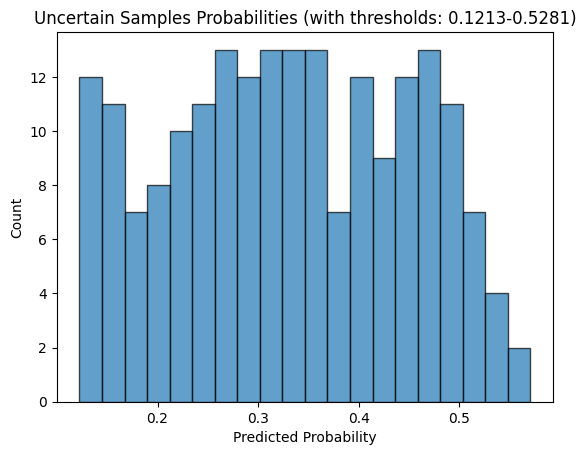

thresholds pair:  [0.02, 0.6]
Thresholds (0.0244, 0.3712): 190 uncertain samples, 20.0000% healthy, 80.0000% sick


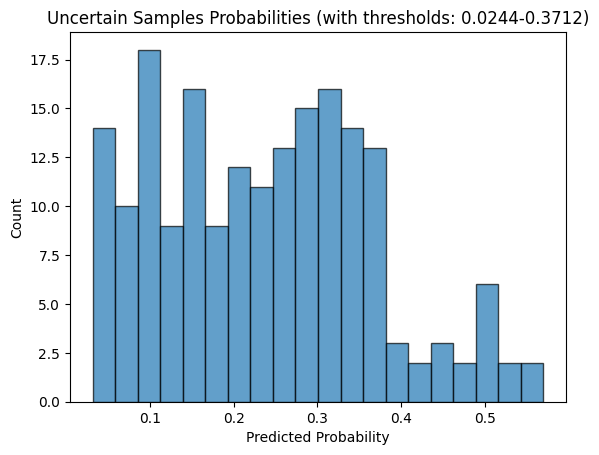

thresholds pair:  [0.05, 0.6]
Thresholds (0.0452, 0.3712): 183 uncertain samples, 17.4863% healthy, 82.5137% sick


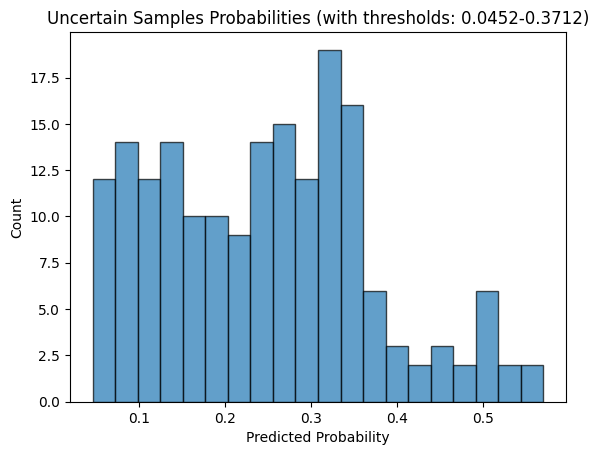

thresholds pair:  [0.02, 0.65]
Thresholds (0.0244, 0.4003): 196 uncertain samples, 19.3878% healthy, 80.6122% sick


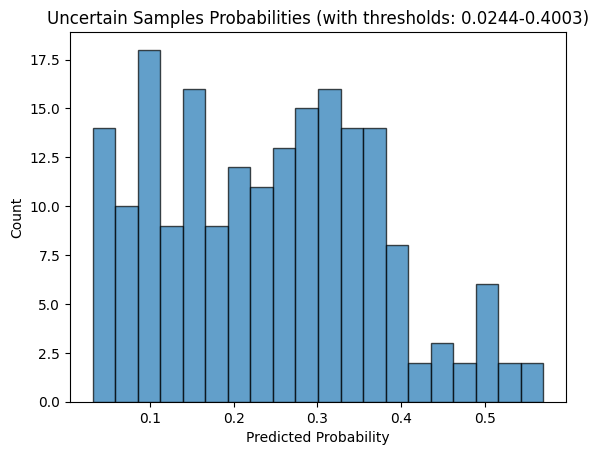

thresholds pair:  [0.05, 0.7]
Thresholds (0.0452, 0.4319): 202 uncertain samples, 15.8416% healthy, 84.1584% sick


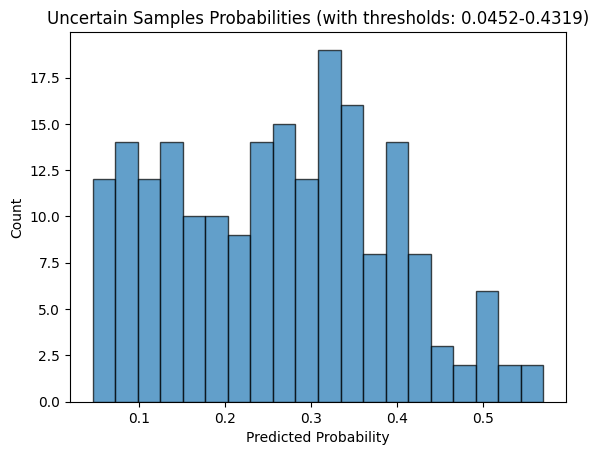

thresholds pair:  [0.02, 0.7]
Thresholds (0.0244, 0.4319): 209 uncertain samples, 18.1818% healthy, 81.8182% sick


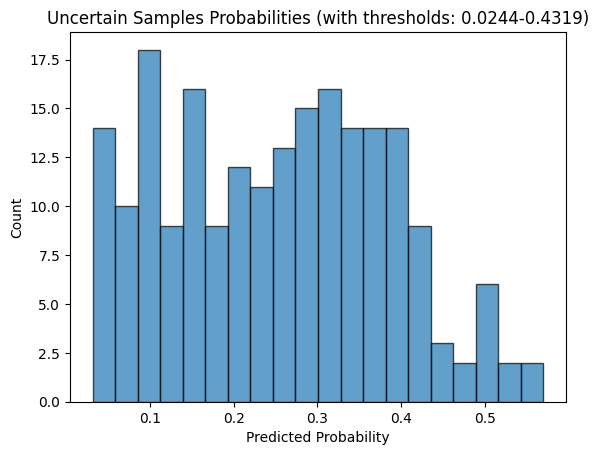

thresholds pair:  [0.08, 0.7]
Thresholds (0.0728, 0.4319): 190 uncertain samples, 11.5789% healthy, 88.4211% sick


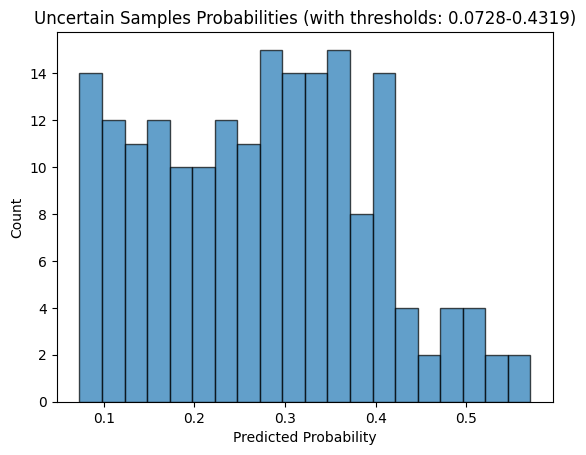

In [108]:
check_first_layer_thresholds(microbiome_and_metabolome_train, labels_train, microbiome_and_metabolome_test, labels_test)

In [109]:
def run_lgbm_with_reweighting(train_data, train_labels, test_data):
    """
    Fits a LightGBM classifier with sample weights to correct for class imbalance.
    The function assumes an initial distribution of 90% sick / 10% healthy in the training data
    and re-weights it to a target of 10% sick / 90% healthy.
    """
    target_ratio = 0.1
    sick_indices = train_labels == 1
    healthy_indices = train_labels == 0
    sick_num = sick_indices.sum()
    healthy_num = healthy_indices.sum()

    w_sick = 1.0
    w_healthy = (w_sick * sick_num * (1 - target_ratio)) / (target_ratio * healthy_num)
    
    # Assign weights per sample
    weights = np.ones_like(train_labels, dtype=float)
    weights[sick_indices] = w_sick
    weights[healthy_indices] = w_healthy

    lgbm = lgb.LGBMClassifier(objective='binary', verbose=-1)
    lgbm.fit(train_data, train_labels, sample_weight=weights)

    probs_test_uncertain = lgbm.predict_proba(test_data)[:, 1]
    return probs_test_uncertain

In [110]:
def second_layer(train_data, train_labels, test_data_uncertain):
    # Run the model on the uncertain data from the first layer
    probs_uncertain = run_lgbm_with_reweighting(train_data, train_labels, test_data_uncertain)
    return probs_uncertain

In [111]:
def two_layer_model(train_data, train_labels, test_data, test_labels):
    test_data_uncertain, test_labels_uncertain, test_labels_certain, test_probs_certain = first_layer(train_data, train_labels, test_data, test_labels)
    test_probs_uncertain = second_layer(train_data, train_labels, test_data_uncertain)
    final_probs = np.zeros_like(test_labels, dtype=float)
    certain_indices = test_labels_certain.index
    uncertain_indices = test_labels_uncertain.index
    mask_certain = np.isin(test_labels.index, certain_indices)
    mask_uncertain = np.isin(test_labels.index, uncertain_indices)
    final_probs[mask_certain] = test_probs_certain
    final_probs[mask_uncertain] = test_probs_uncertain
    aupr_final = aupr_balanced(test_labels, final_probs, True)
    print("AUPR after second layer: ", aupr_final)
    return aupr_final

In [112]:
def cross_validation(microbiome, metabolome, metadata):
    kf = KFold(n_splits=9, shuffle=True, random_state=42)
    aupr_scores = []
    for fold, (train_indices, test_indices) in enumerate(kf.split(microbiome), start=1):
        
        microbiome_train, microbiome_test = microbiome.iloc[train_indices], microbiome.iloc[test_indices]
        metabolome_train, metabolome_test = metabolome.iloc[train_indices], metabolome.iloc[test_indices]
        microbiome_train = clr_transform(microbiome_train)
        microbiome_test = clr_transform(microbiome_test)
        metabolome_train, metabolome_test = standartization_transform(metabolome_train, metabolome_test)
        microbiome_and_metabolome_train = pd.merge(metabolome_train, microbiome_train, left_index=True, right_index=True, how='inner')
        microbiome_and_metabolome_test = pd.merge(metabolome_test, microbiome_test, left_index=True, right_index=True, how='inner')
        metadata['Disease_status'] = metadata['PATGROUPFINAL_C'].apply(lambda x:0 if x == '8' else 1)
        metadata_train = metadata.iloc[train_indices]
        metadata_test = metadata.iloc[test_indices]
        labels_train = metadata_train['Disease_status']
        labels_test = metadata_test['Disease_status']

        aupr = two_layer_model(microbiome_and_metabolome_train, labels_train, microbiome_and_metabolome_test, labels_test)
        aupr_scores.append(aupr)
    print("Mean AUPR:", np.mean(aupr_scores))

AUPR of first layer only is:  0.7404044613422152


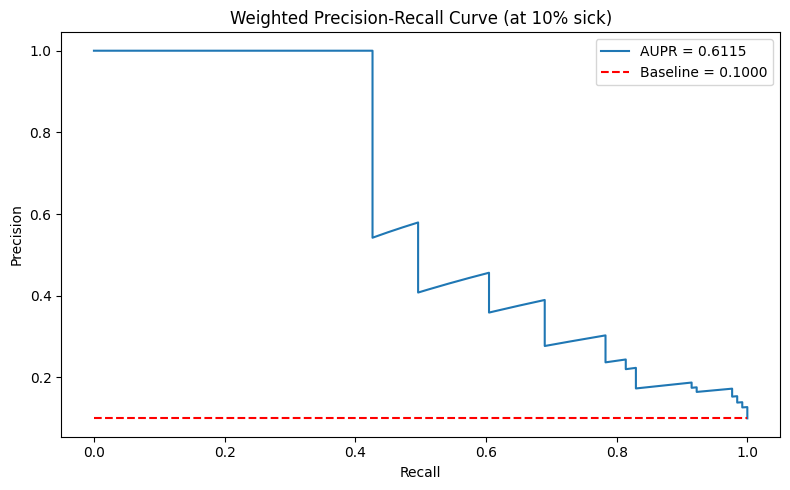

AUPR after second layer:  0.6115043300103267
AUPR of first layer only is:  0.6669635655648962


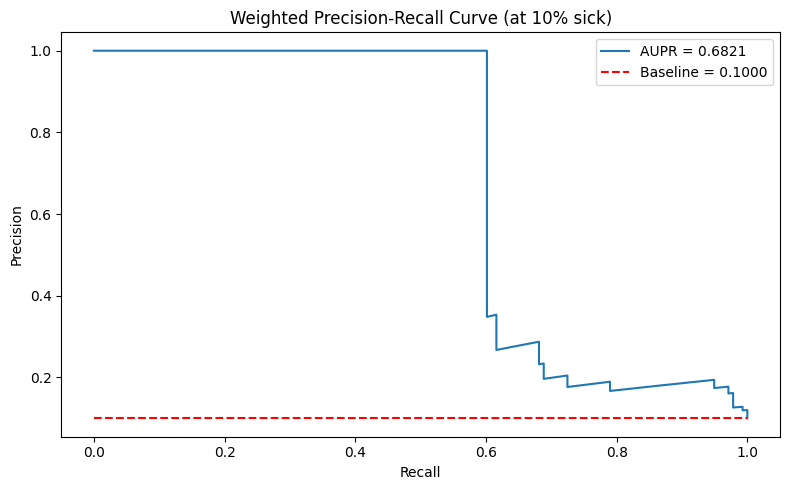

AUPR after second layer:  0.6820894975051889
AUPR of first layer only is:  0.8128968210903551


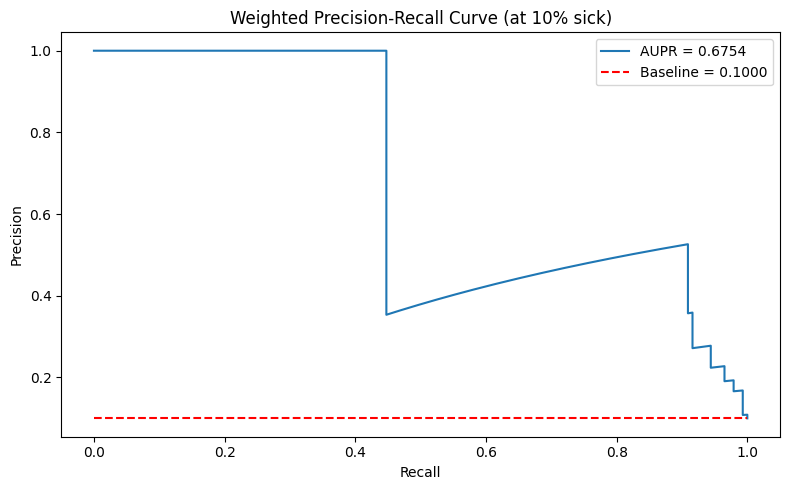

AUPR after second layer:  0.6754352274537843
AUPR of first layer only is:  0.4637244375902215


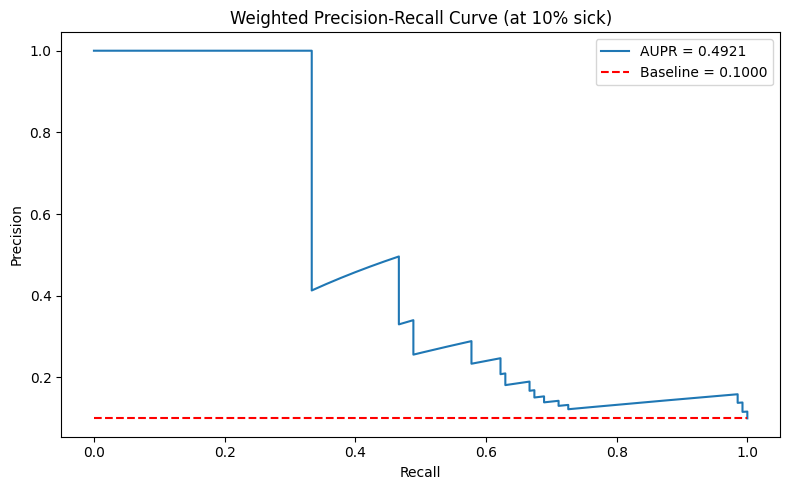

AUPR after second layer:  0.49205183001642705
AUPR of first layer only is:  0.7091339018043504


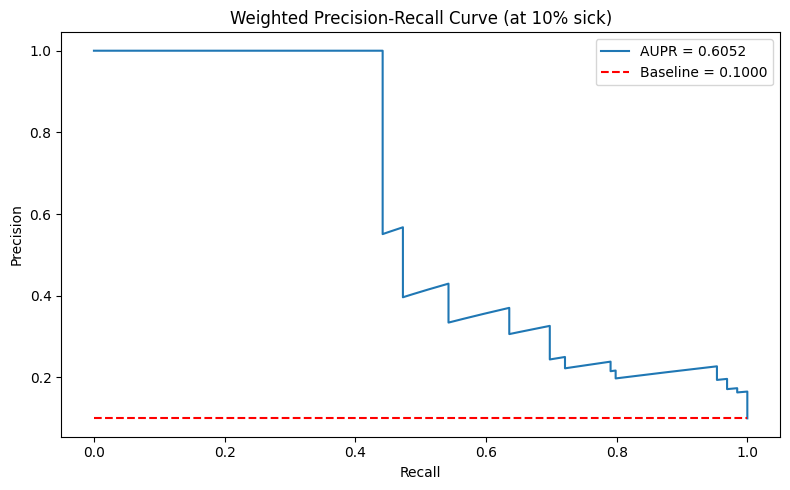

AUPR after second layer:  0.605247978892772
AUPR of first layer only is:  0.6608807039761764


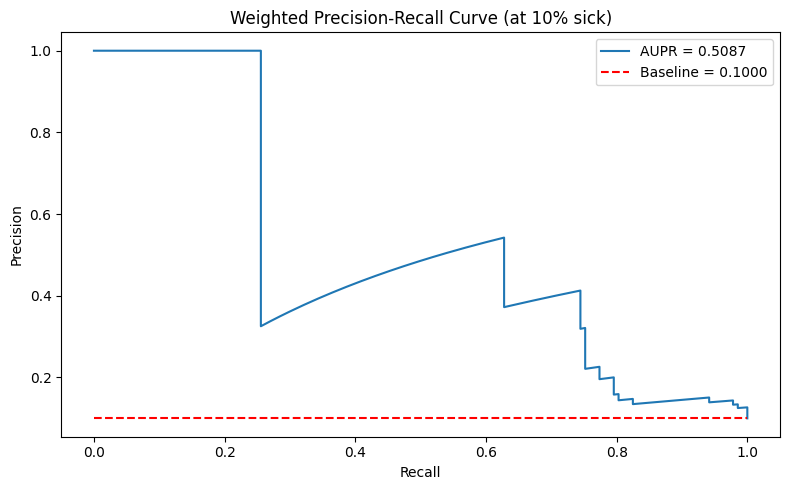

AUPR after second layer:  0.5087292883641683


In [ ]:
cross_validation(microbiome, metabolome, metadata)